# ResNet9 on MNIST – Companion Notebook for Chapter 4

This notebook accompanies **Chapter 4 (Neural Networks)** of the *Mathematics of Generative AI* living book, 
specifically the discussion of **convolutional networks and residual architectures** (Section 4.2: CNN → ResNet → Neural ODE).

It provides a concrete PyTorch implementation of a small **ResNet9** model trained on MNIST and is intended to:
- Illustrate how skip connections modify optimization and representation dynamics compared to plain CNNs.
- Visualize training and test accuracy curves.
- Offer hands-on experiments related to the ResNet/Neural-ODE viewpoint in the text.

> This notebook is optional and exploratory: it is meant to support intuition, not to serve as a production implementation.


Epoch [1/10], Loss: 0.2213
Epoch [2/10], Loss: 0.0612
Epoch [3/10], Loss: 0.0476
Epoch [4/10], Loss: 0.0395
Epoch [5/10], Loss: 0.0336
Epoch [6/10], Loss: 0.0290
Epoch [7/10], Loss: 0.0287
Epoch [8/10], Loss: 0.0222
Epoch [9/10], Loss: 0.0217
Epoch [10/10], Loss: 0.0190


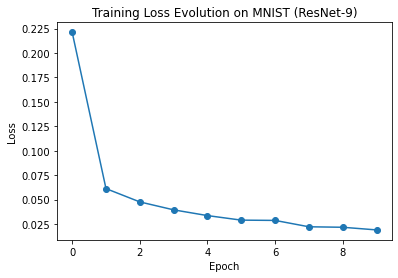

Test Accuracy: 99.19%


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


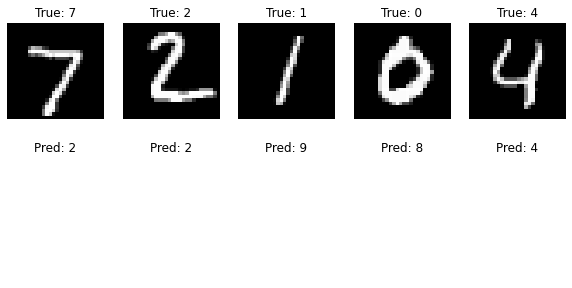

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set random seed for reproducibility
torch.manual_seed(0)

# Define transformations for MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize MNIST images
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define ResNet-9 Model for MNIST
class ResNet9(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet9, self).__init__()
        
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Residual block 1 (with skip connection adjustment)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.shortcut1 = nn.Conv2d(64, 128, kernel_size=1, stride=1, bias=False)  # Match dimensions

        # Residual block 2 (with skip connection adjustment)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)
        self.shortcut2 = nn.Conv2d(128, 256, kernel_size=1, stride=1, bias=False)  # Match dimensions

        # Global Average Pooling and Fully Connected Layer
        self.pool = nn.AdaptiveAvgPool2d(1)  # GAP
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # Initial Conv Layer
        
        # Residual Block 1
        residual = self.shortcut1(x)  # Adjust dimensions using 1x1 conv
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x += residual  # Skip connection
        x = F.relu(x)

        # Residual Block 2
        residual = self.shortcut2(x)  # Adjust dimensions using 1x1 conv
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.bn5(self.conv5(x))
        x += residual  # Skip connection
        x = F.relu(x)

        # Global Average Pooling + Fully Connected Layer
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Initialize model, loss function, and optimizer
model = ResNet9()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
loss_history = []

for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Plot training loss evolution
plt.figure(figsize=(6, 4))
plt.plot(loss_history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Evolution on MNIST (ResNet-9)")
plt.show()

# Evaluate on test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Visualize test classification results
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(5):
    sample_image, sample_label = test_dataset[i]
    sample_image = sample_image.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = model(sample_image)
        predicted_label = torch.argmax(output, dim=1).item()

    axes[0, i].imshow(sample_image.squeeze(0).squeeze(0), cmap="gray")
    axes[0, i].set_title(f"True: {sample_label}")
    axes[1, i].set_title(f"Pred: {predicted_label}")

for ax in axes.flat:
    ax.axis("off")

plt.show()